### 贝叶斯新闻分类任务

- 新闻数据集处理

爬取的新闻数据，需要我们对文本数据进行很多预处理才能使用

- 文本分词

通常我们处理的都是词而不是一篇文章

- 去停用词

停用词会对结果产生不好的影响，所以一定得把他们去剔除掉

- 构建文本特征

如何构建合适特征是自然语言处理中最重要的一步，这俩我们选择两种方案来进行对比

- 贝叶斯分类

基于贝叶斯算法来完成最终的分类任务

In [1]:
import pandas as pd
import jieba
#pip install jieba

### 数据源：http://www.sogou.com/labs/resource/ca.php 

这回我们要做的是一个新闻分类任务，也就是根据新闻的内容来判断它属于哪一个类别，先来看一下数据长什么样子把：

In [2]:
df_news = pd.read_table('./data/data.txt',names=['category','theme','URL','content'],encoding='utf-8')
df_news = df_news.dropna()
df_news.tail()

,category,theme,URL,content
4995,时尚,常吃六类食物快速补充水分,http://lady.people.com.cn/GB/18248366.html,随着天气逐渐炎热，补水变得日益重要。据美国《跑步世界》杂志报道，喝水并不是为身体补充水分的唯...
4996,时尚,情感：你是我的那盘菜 吃不起我走【２】,http://lady.people.com.cn/n/2012/0712/c1014-18...,我其实不想说这些话刺激他，他也是不得已。可是，我又该怎样说，怎样做？我只能走，离开这个伤心地...
4997,时尚,揭秘不老女神刘晓庆的四任丈夫（图）,http://lady.people.com.cn/n/2012/0730/c1014-18...,５８岁刘晓庆最新嫩照Ｏ衷诘牧跸庆绝对看不出她已经５８岁了，她绝对可以秒杀刘亦菲、范冰冰这类美...
4998,时尚,样板潮爸 时尚圈里的父亲们,http://lady.people.com.cn/GB/18215232.html,导语：做了爸爸就是一种幸福，无论是领养还是亲生，更何况出现在影视剧中。时尚圈永远是需要领军人...
4999,时尚,全球最美女人长啥样？中国最美女人酷似章子怡（图）,http://lady.people.com.cn/BIG5/n/2012/0727/c10...,全球最美女人合成图：：国整形外科教授李承哲，在国际学术杂志美容整形外科学会学报发表了考虑种族...


于原始数据都是由爬虫爬下来的，所以看起来有些不整洁，一会我们还需要清洗一番。这里我们自己定义个字段：

- Category:当前新闻所属的类别，一会我们要进行分别任务，这就是标签了。
- Theme:新闻的主题，这个咱们先暂时不用，大家在练习的时候也可以把它当作特征。
- URL：爬取的界面的链接，方便检验爬取数据是不是完整的，这个咱们暂时也不需要。
- Content:新闻的内容，这些就是一篇文章了，里面的内容还是很丰富的。

看看现在的数据规模

In [3]:
df_news.shape

(5000, 4)

任务已经很明确了，根据文章的内容来进行类别的划分。那如何做这个事呢？咱们之前看到的数据都是数值的，直接传入到算法中求解参数就可以了。这份数据就有些特别了，都是文本，计算机可不认识这些文字呀，所以我们需要把这些文字转换成特征，比如说将一篇文章转换成一个向量，这样就可以玩起来了。
对于一篇文章来说，里面的内容还是有点太多了，如果直接把它转换成向量，有一串数字来表示这篇文章，一方面来说难度有些大，另一方面这些表示的效果也不尽如人意。通常的做法都是先把文章进行分词，然后在词的层面上去做文章。先拿到一篇文章，然后我们再看看其分词的结果：

###  中文分词
对于文本分类来说，直接对一篇完整的文章来建模有些难度，一般情况下我们都是先把文章进行分词，然后在词上做文章，先拿一篇新闻看看长什么样

In [4]:
content = df_news.content.values.tolist() #将每一篇文章转换成一个list
print (content[1000]) #随便选择其中一个看看

阿里巴巴集团昨日宣布，将在集团管理层面设立首席数据官岗位（Ｃｈｉｅｆ　Ｄａｔａ　Ｏｆｆｉｃｅｒ），阿里巴巴Ｂ２Ｂ公司ＣＥＯ陆兆禧将会出任上述职务，向集团ＣＥＯ马云直接汇报。＞菹ぃ和６月初的首席风险官职务任命相同，首席数据官亦为阿里巴巴集团在完成与雅虎股权谈判，推进“ｏｎｅ　ｃｏｍｐａｎｙ”目标后，在集团决策层面新增的管理岗位。０⒗锛团昨日表示，“变成一家真正意义上的数据公司”已是战略共识。记者刘夏


使用结巴分词

In [5]:
content_S = []
for line in content:
    current_segment = jieba.lcut(line) #对每一篇文章进行分词
    if len(current_segment) > 1 and current_segment != '\r\n': #换行符
        content_S.append(current_segment) #保存分词的结果

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.532 seconds.
Prefix dict has been built succesfully.


看看其中一条的分词结果

In [6]:
content_S[1000]

['阿里巴巴',
 '集团',
 '昨日',
 '宣布',
 '，',
 '将',
 '在',
 '集团',
 '管理',
 '层面',
 '设立',
 '首席',
 '数据',
 '官',
 '岗位',
 '（',
 'Ｃ',
 'ｈ',
 'ｉ',
 'ｅ',
 'ｆ',
 '\u3000',
 'Ｄ',
 'ａ',
 'ｔ',
 'ａ',
 '\u3000',
 'Ｏ',
 'ｆ',
 'ｆ',
 'ｉ',
 'ｃ',
 'ｅ',
 'ｒ',
 '）',
 '，',
 '阿里巴巴',
 'Ｂ',
 '２',
 'Ｂ',
 '公司',
 'Ｃ',
 'Ｅ',
 'Ｏ',
 '陆兆禧',
 '将',
 '会',
 '出任',
 '上述',
 '职务',
 '，',
 '向',
 '集团',
 'Ｃ',
 'Ｅ',
 'Ｏ',
 '马云',
 '直接',
 '汇报',
 '。',
 '＞',
 '菹',
 'ぃ',
 '和',
 '６',
 '月初',
 '的',
 '首席',
 '风险',
 '官',
 '职务',
 '任命',
 '相同',
 '，',
 '首席',
 '数据',
 '官亦为',
 '阿里巴巴',
 '集团',
 '在',
 '完成',
 '与',
 '雅虎',
 '股权',
 '谈判',
 '，',
 '推进',
 '“',
 'ｏ',
 'ｎ',
 'ｅ',
 '\u3000',
 'ｃ',
 'ｏ',
 'ｍ',
 'ｐ',
 'ａ',
 'ｎ',
 'ｙ',
 '”',
 '目标',
 '后',
 '，',
 '在',
 '集团',
 '决策',
 '层面',
 '新增',
 '的',
 '管理',
 '岗位',
 '。',
 '０',
 '⒗',
 '锛',
 '团',
 '昨日',
 '表示',
 '，',
 '“',
 '变成',
 '一家',
 '真正',
 '意义',
 '上',
 '的',
 '数据',
 '公司',
 '”',
 '已',
 '是',
 '战略',
 '共识',
 '。',
 '记者',
 '刘夏']

In [7]:
df_content=pd.DataFrame({'content_S':content_S}) #专门展示分词后的结果
df_content.head()

,content_S
0,"[经销商, , 电话, , 试驾, ／, 订车, Ｕ, 憬, 杭州, 滨江区, 江陵, ..."
1,"[呼叫, 热线, , ４, ０, ０, ８, －, １, ０, ０, －, ３, ０, ０..."
2,"[Ｍ, Ｉ, Ｎ, Ｉ, 品牌, 在, 二月, 曾经, 公布, 了, 最新, 的, Ｍ, Ｉ..."
3,"[清仓, 大, 甩卖, ！, 一汽, 夏利, Ｎ, ５, 、, 威志, Ｖ, ２, 低至, ..."
4,"[在, 今年, ３, 月, 的, 日内瓦, 车展, 上, ，, 我们, 见到, 了, 高尔夫..."


完成了分词任务之后，我们要处理的对象就是其中每一个词了，但是这里我们得先考虑一个问题，一篇文章是什么主题应该是由其内容中的一些关键词来决定的，比如这里的‘车展’，‘跑车’，‘发动机’等，这些词我们一看就知道跟汽车相关的。但是另一类词，‘今天’，‘在’，‘3月份’等，这些词给我们的感觉好像既可以在汽车相关的文章中使用，也可以在其他类型的文章使用，就把它们称作停用词，也就是我们一会要过滤的目标。
首先需要选择一个合适的停用词库，这些网上有很多现成的，但是都没那么完整，所以当大家在进行数据清洗任务的时候还需要自己添加一些，先来看看停用词表长什么样子吧：

In [8]:
stopwords=pd.read_csv("stopwords.txt",index_col=False,sep="\t",quoting=3,names=['stopword'], encoding='utf-8')
stopwords.head(20)

,stopword
0,!
1,""""
2,#
3,$
4,%
5,&
6,'
7,(
8,)
9,*


筛选顾虑掉那些停用词

In [9]:
def drop_stopwords(contents,stopwords):
    contents_clean = []
    all_words = []
    for line in contents:
        line_clean = []
        for word in line:
            if word in stopwords:
                continue
            line_clean.append(word)
            all_words.append(str(word))
        contents_clean.append(line_clean)
    return contents_clean,all_words
    
contents = df_content.content_S.values.tolist()    
stopwords = stopwords.stopword.values.tolist()
contents_clean,all_words = drop_stopwords(contents,stopwords)

#df_content.content_S.isin(stopwords.stopword)
#df_content=df_content[~df_content.content_S.isin(stopwords.stopword)]
#df_content.head()

In [10]:
df_content=pd.DataFrame({'contents_clean':contents_clean})
df_content.head()

,contents_clean
0,"[经销商, 电话, 试驾, 订车, Ｕ, 憬, 杭州, 滨江区, 江陵, 路, 号, 转, ..."
1,"[呼叫, 热线, 服务, 邮箱, ｋ, ｆ, ｐ, ｅ, ｏ, ｐ, ｌ, ｅ, ｄ, ａ,..."
2,"[Ｍ, Ｉ, Ｎ, Ｉ, 品牌, 二月, 公布, 最新, Ｍ, Ｉ, Ｎ, Ｉ, 新, 概念..."
3,"[清仓, 甩卖, 一汽, 夏利, Ｎ, 威志, Ｖ, 低至, 万, 启新, 中国, 一汽, ..."
4,"[日内瓦, 车展, 见到, 高尔夫, 家族, 新, 成员, 高尔夫, 敞篷版, 款, 全新,..."


就看这里最后一条数据吧，没过滤之前:
[在, 今年, ３, 月, 的, 日内瓦, 车展, 上, ，, 我们, 见到, 了, 高尔夫...
过滤之后:
[日内瓦, 车展, 见到, 高尔夫, 家族, 新, 成员, 高尔夫, 敞篷版, 款, 全新,...

虽然这份停用词表没有做的十分完善，但是已经可以基本完成清洗的任务了，大家可以酌情再来完善这份词表。
 
 
 
下面再给大家介绍一个文本可视化的利器：词云。在Python中可以用wordcloud工具包来做这个事，到现在我们已经介绍了好几个Python实用的工具了，以后大家还会用到更多的，建议大家使用这些工具包的时候不要先百度一些文档，因为这些可能已经过时了，工具包都会进行更新升级的。可以先参考其github文档：

In [11]:
df_all_words=pd.DataFrame({'all_words':all_words})
df_all_words.head()

,all_words
0,经销商
1,电话
2,试驾
3,订车
4,Ｕ


In [12]:
import numpy
words_count=df_all_words.groupby(by=['all_words'])['all_words'].agg({"count":numpy.size})
words_count=words_count.reset_index().sort_values(by=["count"],ascending=False)
words_count.head()

e:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


,all_words,count
4077,中,5199
4209,中国,3115
88255,说,3055
104747,Ｓ,2646
1373,万,2390


### 词云展示

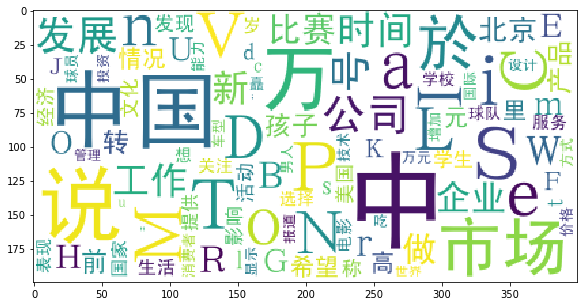

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0)

wordcloud=WordCloud(font_path="./data/simhei.ttf",background_color="white",max_font_size=80)
word_frequence = {x[0]:x[1] for x in words_count.head(100).values}
wordcloud=wordcloud.fit_words(word_frequence)
plt.imshow(wordcloud)

###  TF-IDF ：提取关键词###

下面我们再来看一下TF-IDF：关键词提取方法。在一篇文章中，我们经过清洗之后，剩下的都是稍微有价值的词，但是这些词的重要程度是一样的嘛？还是各有高低吧，假设我想从一篇文章找出最有价值的几个词该怎么办呢？如果只按照词频来统计，得到结果可能不会太好，因为词频高的可能都是一些套话并不是主题。这时候TF-IDF就派上用场了。
这里，借用一个经典的例子，我手里有一篇文章<中国的蜜蜂养殖>：

当我进行词频统计的时候，发现这篇文章中，‘中国’，‘蜜蜂’，‘养殖’这三个词出现的次数是一样的，比如都是10次，那这个时候如果判断其重要性呢？这一篇文章应该讲述的是都跟蜜蜂和养殖相关的技术，所以这俩词应当是重点了。而中国这个词，我们既可以说中国的蜜蜂，还可以说中国的篮球，中国的大熊猫，能派上用场的地方简直太多了，没有那么专一，所以在这篇文章中它应当不是那么重要的。
这里我们就可以给出一个合理的定义了，如果一个词在整个语料库中（可以当作是在所有文章中）出现的次数都很高（这篇也有它，另一片还有这个词），那么这个词的重要程度就不高，因为它更像一个通用词。如果另一个词在整体的预料库中的词频很低，但是在这一篇文章中的词频却很高，我们就有理由认为它在这篇文章中就很重要了。比如蜜蜂这个词，在篮球，大熊猫相关的文章中基本不可能出现，这里却大量出现了。

In [14]:
import jieba.analyse #工具包
index = 2400 #随便找一篇文章就行
content_S_str = "".join(content_S[index]) #把分词的结果组合在一起，形成一个句子
print (content_S_str) #打印这个句子
print ("  ".join(jieba.analyse.extract_tags(content_S_str, topK=5, withWeight=False)))#选出来5个核心词

法国ＶＳ西班牙、里贝里ＶＳ哈维，北京时间６月２４日凌晨一场的大战举世瞩目，而这场胜利不仅仅关乎两支顶级强队的命运，同时也是他们背后的球衣赞助商耐克和阿迪达斯之间的一次角逐。Ｔ谌胙”窘炫分薇的１６支球队之中，阿迪达斯和耐克的势力范围也是几乎旗鼓相当：其中有５家球衣由耐克提供，而阿迪达斯则赞助了６家，此外茵宝有３家，而剩下的两家则由彪马赞助。而当比赛进行到现在，率先挺进四强的两支球队分别被耐克支持的葡萄牙和阿迪达斯支持的德国占据，而由于最后一场１／４决赛是茵宝（英格兰）和彪马（意大利）的对决，这也意味着明天凌晨西班牙同法国这场阿迪达斯和耐克在１／４决赛的唯一一次直接交手将直接决定两家体育巨头在此次欧洲杯上的胜负。８据评估，在２０１２年足球商品的销售额能总共超过４０亿欧元，而单单是不足一个月的欧洲杯就有高达５亿的销售额，也就是说在欧洲杯期间将有７００万件球衣被抢购一空。根据市场评估，两大巨头阿迪达斯和耐克的市场占有率也是并驾齐驱，其中前者占据３８％，而后者占据３６％。体育权利顾问奥利弗－米歇尔在接受《队报》采访时说：“欧洲杯是耐克通过法国翻身的一个绝佳机会！”Ｃ仔尔接着谈到两大赞助商的经营策略：“竞技体育的成功会燃起球衣购买的热情，不过即便是水平相当，不同国家之间的欧洲杯效应却存在不同。在德国就很出色，大约１／４的德国人通过电视观看了比赛，而在西班牙效果则差很多，由于民族主义高涨的加泰罗尼亚地区只关注巴萨和巴萨的球衣，他们对西班牙国家队根本没什么兴趣。”因此尽管西班牙接连拿下欧洲杯和世界杯，但是阿迪达斯只为西班牙足协支付每年２６００万的赞助费＃相比之下尽管最近两届大赛表现糟糕法国足协将从耐克手中每年可以得到４０００万欧元。米歇尔解释道：“法国创纪录的４０００万欧元赞助费得益于阿迪达斯和耐克竞逐未来１５年欧洲市场的竞争。耐克需要笼络一个大国来打赢这场欧洲大陆的战争，而尽管德国拿到的赞助费并不太高，但是他们却显然牢牢掌握在民族品牌阿迪达斯手中。从长期投资来看，耐克给法国的赞助并不算过高。”
耐克  阿迪达斯  欧洲杯  球衣  西班牙


简单过一遍文章可以发现，讲的大概就是足球比赛赞助商各自的发展策略，得到的关键词结果也是跟我们预计是一致的。关键词提取方法还是很实用的，想一想我们每天使用各种APP都能看到很多广告，大家的广告应该是各不相同的，比如我的基本都是跟游戏相关，因为我平时的关注点就在这些，我想这些APP已经给我打上的标签可能就是：王者荣耀，手机游戏，死肥宅。。。TF-IDF算法打标签中最容易的一种了，介绍了几种文本处理方法，接下来我们还需把重点放回到我们的分类任务中，也就是要进行文本特征提取。

In [15]:
df_train=pd.DataFrame({'contents_clean':contents_clean,'label':df_news['category']})
df_train.tail()

,contents_clean,label
4995,"[天气, 炎热, 补水, 变得, 美国, 跑步, 世界, 杂志, 报道, 喝水, 身体, 补...",时尚
4996,"[不想, 说, 话, 刺激, 说, 做, 只能, 走, 离开, 伤心地, 想起, 一句, 话...",时尚
4997,"[岁, 刘晓庆, 最新, 嫩照, Ｏ, 衷, 诘, 牧跸, 庆, 看不出, 岁, 秒杀, 刘...",时尚
4998,"[导语, 做, 爸爸, 一种, 幸福, 无论是, 领养, 亲生, 更何况, 影视剧, 中, ...",时尚
4999,"[全球, 最美, 女人, 合成图, 国, 整形外科, 教授, 李承哲, 国际, 学术, 杂志...",时尚


数据集标签制作

In [16]:
df_train.label.unique()

array(['汽车', '财经', '科技', '健康', '体育', '教育', '文化', '军事', '娱乐', '时尚'], dtype=object)

In [17]:
label_mapping = {"汽车": 1, "财经": 2, "科技": 3, "健康": 4, "体育":5, "教育": 6,"文化": 7,"军事": 8,"娱乐": 9,"时尚": 0}
df_train['label'] = df_train['label'].map(label_mapping) #构建一个映射方法
df_train.head()

,contents_clean,label
0,"[经销商, 电话, 试驾, 订车, Ｕ, 憬, 杭州, 滨江区, 江陵, 路, 号, 转, ...",1
1,"[呼叫, 热线, 服务, 邮箱, ｋ, ｆ, ｐ, ｅ, ｏ, ｐ, ｌ, ｅ, ｄ, ａ,...",1
2,"[Ｍ, Ｉ, Ｎ, Ｉ, 品牌, 二月, 公布, 最新, Ｍ, Ｉ, Ｎ, Ｉ, 新, 概念...",1
3,"[清仓, 甩卖, 一汽, 夏利, Ｎ, 威志, Ｖ, 低至, 万, 启新, 中国, 一汽, ...",1
4,"[日内瓦, 车展, 见到, 高尔夫, 家族, 新, 成员, 高尔夫, 敞篷版, 款, 全新,...",1


In [18]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df_train['contents_clean'].values, df_train['label'].values, random_state=1)

In [20]:
#x_train = x_train.flatten()
x_train[0][1]

'上海'

In [21]:
words = []
for line_index in range(len(x_train)):
    try:
        #x_train[line_index][word_index] = str(x_train[line_index][word_index])
        words.append(' '.join(x_train[line_index]))
    except:
        print (line_index,word_index)
words[0]        

'中新网 上海 日电 于俊 父亲节 网络 吃 一顿 电影 快餐 微 电影 爸 对不起 我爱你 定于 本月 父亲节 当天 各大 视频 网站 首映 葜 谱 鞣 剑 保慈 障蚣 钦 呓 樯 埽 ⒌ 缬 埃 ǎ 停 椋 悖 颍 铩 妫 椋 恚 称 微型 电影 新 媒体 平台 播放 状态 短时 休闲 状态 观看 完整 策划 系统 制作 体系 支持 显示 较完整 故事情节 电影 微 超短 放映 微 周期 制作 天 数周 微 规模 投资 人民币 几千 数万元 每部 内容 融合 幽默 搞怪 时尚 潮流 人文 言情 公益 教育 商业 定制 主题 单独 成篇 系列 成剧 唇 开播 微 电影 爸 对不起 我爱你 讲述 一对 父子 观念 缺少 沟通 导致 关系 父亲 传统 固执 钟情 传统 生活 方式 儿子 新派 音乐 达 习惯 晚出 早 生活 性格 张扬 叛逆 两种 截然不同 生活 方式 理念 差异 一场 父子 间 拉开序幕 子 失手 打破 父亲 心爱 物品 父亲 赶出 家门 剧情 演绎 父亲节 妹妹 哥哥 化解 父亲 这场 矛盾 映逋坏 嚼 斫 狻 ⒍ 粤 ⒌ 桨容 争执 退让 传统 尴尬 父子 尴尬 情 男人 表达 心中 那份 感恩 一杯 滤挂 咖啡 父亲节 变得 温馨 镁 缬 缮 虾 Ｎ 逄 煳 幕 传播 迪欧 咖啡 联合 出品 出品人 希望 观摩 扪心自问 父亲节 父亲 记得 父亲 生日 哪一天 父亲 爱喝 跨出 家门 那一刻 感觉 一颗 颤动 心 操劳 天下 儿女 父亲节 大声 喊出 父亲 家人 爱 完'

In [242]:
print (len(words))

3750


### 制作词袋模型特征

In [243]:
from sklearn.feature_extraction.text import CountVectorizer
texts=["dog cat fish","dog cat cat","fish bird", 'bird'] #为了简单期间，这里4句话我们就当做4篇文章了
cv = CountVectorizer() #词频统计
cv_fit=cv.fit_transform(texts) #转换数据

print(cv.get_feature_names())
print(cv_fit.toarray())


print(cv_fit.toarray().sum(axis=0))

['bird', 'cat', 'dog', 'fish']
[[0 1 1 1]
 [0 2 1 0]
 [1 0 0 1]
 [1 0 0 0]]
[2 3 2 2]


在sklearn的feature_extraction.text模块中导入了CountVectorizer，也就是我们词袋模型要用的模块，这里还有很多丰富的文本处理方法，感兴趣的同学也可以来尝试一下其他方法。为了简单起见，构造了4个句子，我们暂且当做4篇文章就好。观察可以发现，这四篇文章中总共包含了4个词：'bird', 'cat', 'dog', 'fish'。所以词袋模型的向量长度就是4了，在结果中我们打印了get_feature_names()得到了特征中各个位置的含义，例如第一个句子"dog cat fish"得到的向量为：[0 1 1 1]，它的意思就是首先看第一个位置'bird'在这句话中有没有出现，出现了几次，结果为0；接下来同样看 'cat'，发现出现了1次，那向量的第二个位置就为1；同理 'dog', 'fish'在这句话中也各出现了1次，最终的结果就得到了。
词袋模型是自然语言处理中最基础的一种特征提取方法了，说白了它就是看每一个词出现几次，来统计词频就可以了，再把所有出现的词组成特征的名字，依次统计其个数就可以得到文本特征了。这里给我们的感觉有点过于简单了，只考虑词频而不考虑词出现的位置以及先后顺序，那能不能稍微再改进一些呢？这里我们还可以通过设置ngram_range来控制特征的复杂度，比如我们不光可以考虑单单一个词，还可以考虑两个词连在一起，甚至更多的词连在一起。

In [248]:
from sklearn.feature_extraction.text import CountVectorizer
texts=["dog cat fish","dog cat cat","fish bird", 'bird']
cv = CountVectorizer(ngram_range=(1,4)) #设置ngram参数，让结果不光包含一个词，还有2个，3个的组合
cv_fit=cv.fit_transform(texts)

print(cv.get_feature_names())
print(cv_fit.toarray())


print(cv_fit.toarray().sum(axis=0))

['bird', 'cat', 'cat cat', 'cat fish', 'dog', 'dog cat', 'dog cat cat', 'dog cat fish', 'fish', 'fish bird']
[[0 1 0 1 1 1 0 1 1 0]
 [0 2 1 0 1 1 1 0 0 0]
 [1 0 0 0 0 0 0 0 1 1]
 [1 0 0 0 0 0 0 0 0 0]]
[2 3 1 1 2 2 1 1 2 1]


这里我们只加入了ngram_range=(1,4)参数，其它保持不变，观察结果中的特征名字可以发现，这回就不单单是一个词了，而且有两个组合，三个组合在一起。例如'cat cat'表示文本中出现'cat'词后面又跟了一个'cat'词出现的个数。跟之前的单个词来对比，这回我们得到的特征更复杂了一些，特征的长度也明显变多了。可以考虑到上下文的前后关系了，但是这只是我们举的一个简单小例子，看起来还没什么问题。如果实际文本中出现词的个数成千上万了呢？那使用ngram_range=(1,4)参数，得到的词向量的长度就太长了，用起来就很麻烦了。所以通常情况下，ngram参数设置基本为2就够了，再多计算起来就成累赘了。

In [25]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(analyzer='word',lowercase = False)
feature = vec.fit_transform(words)
feature.shape

(3750, 85093)

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(analyzer='word', max_features=4000,  lowercase = False)
feature = vec.fit_transform(words)


In [27]:
feature.shape

(3750, 4000)

在构建过程中，我们还额外加入了一个限制条件max_features=4000，表示我们的特征最大长度为4000，这就会自动过滤掉一些词频较小的词语了。如果不进行限制的话，最终得到的向量长度为85093，大家也可以去掉这个参数来自己观察下，这会使得特征长度过大，而且里面很多都是词频很低的词语，也会导致特征过于稀疏，这些对我们建模来说都是不利的，所以还是非常有必要加上这样一个限制参数。

### 使用词袋模型的特征来建模，观察结果

In [30]:
from sklearn.naive_bayes import MultinomialNB #贝叶斯模型
classifier = MultinomialNB() 
classifier.fit(feature, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [31]:
test_words = []
for line_index in range(len(x_test)):
    try:
        #
        test_words.append(' '.join(x_test[line_index]))
    except:
         print (line_index,word_index)
test_words[0]

'国家 公务员 考试 申论 应用文 类 试题 实质 一道 集 概括 分析 提出 解决问题 一体 综合性 试题 说 一道 客观 凝练 申发 论述 文章 题目 分析 历年 国考 申论 真题 公文 类 试题 类型 多样 包括 公文 类 事务性 文书 类 题材 从题 干 作答 材料 内容 整合 分析 无需 太 创造性 发挥 纵观 历年 申论 真题 作答 应用文 类 试题 文种 格式 作出 特别 重在 内容 考查 行文 格式 考生 平常心 面对 应用文 类 试题 准确 把握 作答 领会 内在 含义 把握 题材 主旨 材料 结构 轻松 应对 应用文 类 试题 Ｒ 弧 ⒆ 钒 盐 展文 写作 原则 Ｔ 材料 中来 应用文 类 试题 材料 总体 把握 客观 考生 材料 中来 材料 中 把握 材料 准确 理解 题材 主旨 Ｔ 政府 角度 作答 应用文 类 试题 更应 注重 政府 角度 观点 政府 角度 出发 原则 表述 观点 提出 解决 之策 考生 作答 站 政府 人员 角度 看待 提出 解决问题 Ｔ 文体 结构 形式 考查 重点 文体 结构 大部分 评分 关键点 解答 方法 薄 ⒆ ス 丶 词 明 方向 作答 题目 题干 作答 作答 方向 作答 角度 关键 向导 考生 仔细阅读 题干 作答 抓住 关键词 作答 方向 相关 要点 整理 作答 思路 年国考 地市级 真 题为 例 潦惺姓 府 宣传 推进 近海 水域 污染 整治 工作 请 给定 资料 市政府 工作人员 身份 草拟 一份 宣传 纲要 Ｒ 求 保对 宣传 内容 要点 提纲挈领 陈述 玻 体现 政府 精神 全市 各界 关心 支持 污染 整治 工作 通俗易懂 超过 字 肮 丶 词 近海 水域 污染 整治 工作 市政府 工作人员 身份 宣传 纲要 提纲挈领 陈述 体现 政府 精神 全市 各界 关心 支持 污染 整治 工作 通俗易懂 提示 归结 作答 要点 包括 污染 情况 原因 解决 对策 作答 思路 情况 原因 对策 意义 逻辑 顺序 安排 文章 结构 病 ⒋ 缶殖 龇 ⅲ 明 结构 解答 应用文 类 试题 考生 材料 整体 出发 大局 出发 高屋建瓴 把握 材料 主题 思想 事件 起因 解决 对策 阅读文章 构建 文章 结构 直至 快速 解答 场 ⒗ 硭 乘悸 罚明 逻辑 应用文 类 试题 严密 逻辑思维 情况 原因 对策 意义

In [32]:
classifier.score(vec.transform(test_words), y_test)

0.80400000000000005

在贝叶斯模型中，我们选择了MultinomialNB，这里它额外做了一些平滑处理主要目的就在我们求解先验概率和条件概率的时候避免其值为0。词袋模型的效果看起来还凑合，能不能再改进一些呢？在这份特征中我们是均等的对待每一个次，说白了就是完全看这个词出现的个数，而不管它是什么词，这看起来还是有点问题的，因为对于不同主题来说有些词可能更重要一些，有些词就没什么太多价值。咱们刚刚还讲了tf-idf算法，能不能将其应用在特征之中呢，当然是可以的，还是通过一个小例子来看一下吧：

### 制作TF-IDF特征

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_test = ['卡尔 敌法师 蓝胖子 小小','卡尔 敌法师 蓝胖子 痛苦女王']

tfidf=TfidfVectorizer()
weight=tfidf.fit_transform(X_test).toarray()
word=tfidf.get_feature_names()
print (weight)
for i in range(len(weight)):  
    print (u"第", i, u"篇文章的tf-idf权重特征")
    for j in range(len(word)):
        print (word[j], weight[i][j])

[[ 0.44832087  0.63009934  0.44832087  0.          0.44832087]
 [ 0.44832087  0.          0.44832087  0.63009934  0.44832087]]
第 0 篇文章的tf-idf权重特征
卡尔 0.448320873199
小小 0.630099344518
敌法师 0.448320873199
痛苦女王 0.0
蓝胖子 0.448320873199
第 1 篇文章的tf-idf权重特征
卡尔 0.448320873199
小小 0.0
敌法师 0.448320873199
痛苦女王 0.630099344518
蓝胖子 0.448320873199


我们简单写了两句话，就是要分别构建它俩的特征。一共出现了5个词，所以特征的长度依旧为5这和词袋模型是一样的，接下来我们得到的特征就是每一个词的tf-idf权重值了，把它们组合在一起就形成我们的特征矩阵了。观察可以发现，两篇文章当中，唯一不同就是'小小'和'痛苦女王'，其他词都是一致的，所以要论区分程度的话，还是它俩更重要一些，其权重值自然就更大了。在结果中也分别进行了打印方便大家观察。TfidfVectorizer()函数中我们还可以加入很多参数来控制特征，比如过滤停用词，最大特征个数，词频最大，最小比例限制等，这些都会对结果产生不同的影响，建议大家使用的时候还是先参考其API文档，价值还是蛮大的，并且还有示例代码.

### 使用TF-IDF特征建模来观察结果

In [249]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(analyzer='word', max_features=4000,  lowercase = False)
vectorizer.fit(words)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=4000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [250]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(vectorizer.transform(words), y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [251]:
classifier.score(vectorizer.transform(test_words), y_test)

0.81520000000000004

效果比之前的词袋模型有所提高，这也是我们预料之中，那还有没有其它更好的特征提取方法了呢？这里给大家再简介介绍一下word2vec词向量模型，它是基于神经网络来实现的，这里我们对其细节就不做过多阐述了。它的强大之处在于，不光对词进行了向量话，还会给其一个实际的含义，咱们之前的词袋模型或者tf-idf都是基于词频去做的，并没有实际的含义只是一个数字而已。但是word2vec中每一个词都有实际的意义，只不过只有计算机能读懂它罢了，这样计算机能把词语进行理解，而不单单看其出现的位置和次数了。如果大家对词向量模型感兴趣，可以参考gensim这个工具包，里面提供了非常简洁的函数帮助我们构建特征，不光如此工具包中还包含了很多自然语言处理相关算法的实现，之后大家肯定都会用上的。